1. Query icepyx; see what tracks are available in area of interest

2. Save track numbers, beams, and repeat numbers into a dictionary

3. For each track/beam combination, loop over all possible repeat pairs

    A. Load all beams and all repeats for that track using icepyx (?). For all beams / repeats:
    
        - Do whatever we are doing with ATL03
    
        - Fill in nan gaps with noise
        
    B. For each repeat pair:
        
        - Loop across the along track coordinates: 
        
            Choices: window size, search width, running average window size, step, where to save data geographically
            
            Output: Best lag, corresponding correlation coefficient, equivalent along-track velocity
            
        - Save results in a text file with date collected, dx from ATL03 processing, lat, lon, veloc, correlation coefficient, best lag, # contributing nans

In [1]:
from icepyx import icesat2data as ipd
import os, glob, re, h5py, sys, pyproj
import matplotlib as plt
import shutil
import numpy as np
from pprint import pprint
from astropy.time import Time
from scipy.signal import correlate, detrend
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib widget

In [2]:
datapath = '/home/jovyan/shared/surface_velocity/FIS_ATL06'
ATL06_files=glob.glob(os.path.join(datapath, '*.h5'))




In [3]:
rgts = {}
for filepath in ATL06_files:
    filename = filepath.split('/')[-1]
    rgt = filename.split('_')[3][0:4]
    track = filename.split('_')[3][4:6]
#     print(rgt,track)
    if not rgt in rgts.keys():
        rgts[rgt] = []
        rgts[rgt].append(track)
    else:
        rgts[rgt].append(track)


# all rgt values in our study are are in rgts.keys()
print(rgts.keys())

# available tracks for each rgt are in rgts[rgt]; ex.:
print(rgts['0848'])

# let's work 0848, our first good track friend

dict_keys(['0080', '1131', '0232', '1031', '0634', '0507', '0131', '0192', '0354', '1061', '0492', '0690', '0970', '0187', '0558', '1335', '0741', '0659', '0894', '1183', '0680', '1101', '1168', '0034', '0568', '0705', '0293', '0711', '1040', '0070', '0543', '1244', '1192', '0314', '0126', '1193', '1147', '0253', '0451', '1122', '0994', '0391', '0141', '0979', '0476', '1223', '1137', '0726', '0918', '1314', '1253', '1177', '0750', '0330', '1010', '0193', '0781', '0872', '1299', '0629', '1055', '0695', '0309', '0467', '0802', '0644', '0461', '0415', '0635', '0924', '0482', '1214', '1076', '0573', '0339', '0833', '0171', '0446', '0385', '1336', '0796', '0369', '0756', '1238', '0674', '0903', '0955', '0650', '0772', '0832', '0766', '0513', '0308', '0857', '0720', '1162', '0848', '0202', '0019', '0071', '1138', '1259', '0522', '0390', '1254', '0360', '0933', '1025', '0512', '1000', '1153', '0842', '0400', '1351', '0751', '0628', '0537', '0583', '0878', '1320', '0491', '0552', '0421', '1315

In [4]:
def atl06_to_dict(filename, beam, field_dict=None, index=None, epsg=None):
    """
        Read selected datasets from an ATL06 file

        Input arguments:
            filename: ATl06 file to read
            beam: a string specifying which beam is to be read (ex: gt1l, gt1r, gt2l, etc)
            field_dict: A dictinary describing the fields to be read
                    keys give the group names to be read, 
                    entries are lists of datasets within the groups
            index: which entries in each field to read
            epsg: an EPSG code specifying a projection (see www.epsg.org).  Good choices are:
                for Greenland, 3413 (polar stereographic projection, with Greenland along the Y axis)
                for Antarctica, 3031 (polar stereographic projection, centered on the Pouth Pole)
        Output argument:
            D6: dictionary containing ATL06 data.  Each dataset in 
                dataset_dict has its own entry in D6.  Each dataset 
                in D6 contains a numpy array containing the 
                data
    """
    if field_dict is None:
        field_dict={None:['latitude','longitude','h_li', 'atl06_quality_summary'],\
                    'ground_track':['x_atc','y_atc'],\
                    'fit_statistics':['dh_fit_dx', 'dh_fit_dy']}
    D={}
    # below: file_re = regular expression, it will pull apart the regular expression to get the information from the filename
    file_re=re.compile('ATL06_(?P<date>\d+)_(?P<rgt>\d\d\d\d)(?P<cycle>\d\d)(?P<region>\d\d)_(?P<release>\d\d\d)_(?P<version>\d\d).h5')
    with h5py.File(filename,'r') as h5f:
        for key in field_dict:
            for ds in field_dict[key]:
                if key is not None:
                    ds_name=beam+'/land_ice_segments/'+key+'/'+ds
                else:
                    ds_name=beam+'/land_ice_segments/'+ds
                if index is not None:
                    D[ds]=np.array(h5f[ds_name][index])
                else:
                    D[ds]=np.array(h5f[ds_name])
                if '_FillValue' in h5f[ds_name].attrs:
                    bad_vals=D[ds]==h5f[ds_name].attrs['_FillValue']
                    D[ds]=D[ds].astype(float)
                    D[ds][bad_vals]=np.NaN
        D['data_start_utc'] = h5f['/ancillary_data/data_start_utc'][:]
        D['delta_time'] = h5f['/' + beam + '/land_ice_segments/delta_time'][:]
        D['segment_id'] = h5f['/' + beam + '/land_ice_segments/segment_id'][:]
    if epsg is not None:
        xy=np.array(pyproj.proj.Proj(epsg)(D['longitude'], D['latitude']))
        D['x']=xy[0,:].reshape(D['latitude'].shape)
        D['y']=xy[1,:].reshape(D['latitude'].shape)
    temp=file_re.search(filename)
    D['rgt']=int(temp['rgt'])
    D['cycle']=int(temp['cycle'])
    D['beam']=beam
    return D

# A revised code to plot the elevations of segment midpoints (h_li):
def plot_elevation(D6, ind=None, **kwargs):
    """
    Plot midpoint elevation for each ATL06 segment
    """
    if ind is None:
        ind=np.ones_like(D6['h_li'], dtype=bool)
    # pull out heights of segment midpoints
    h_li = D6['h_li'][ind]
    # pull out along track x coordinates of segment midpoints
    x_atc = D6['x_atc'][ind]

    plt.plot(x_atc, h_li, **kwargs)

# Loop over rgts and do the correlation processing

TOMORROW: START WITH NEXT CELL IN OLD CODE, IMPLEMENT MAKING THE X1 VEC AND LOOPING

In [208]:
cycles = ['03','04','05','06','07'] # not doing 1 and 2, because don't overlap exactly
# this could be future work

beams = ['gt1l','gt1r','gt2l','gt2r','gt3l','gt3r']

# try and smooth without filling nans
dx = 20 # x_atc coordinate distance
smoothing_window_size = int(np.round(40 / dx)) # meters / dx;
# ex., 60 m smoothing window is a 3 point running average smoothed dataset, because each point is 20 m apart
filt = np.ones(smoothing_window_size)
smoothed = True

segment_length = 2000 # m
search_width = 800 # m

along_track_step = 100 # m; how much to jump between each veloc determination

max_percent_nans = 10 # what % of segment length can be nans

velocities = {}   
correlations = {}     
lags = {}
for ir, rgt in enumerate(rgts.keys()):
    if ir <= 20: # just process a few for the moment
        ### load all files for this rgt
        rgt_files = glob.glob(os.path.join(datapath, f'*ATL06_*_{rgt}*_003*.h5'))

        ### extract data from all available cycles
        x_atc = {}
        h_li_raw = {} # unsmoothed data; equally spaced x_atc, still has nans 
        h_li_raw_NoNans = {} # unsmoothed data; equally spaced x_atc, nans filled with noise
        h_li = {} # smoothed data, equally spaced x_atc, nans filled with noise 
        h_li_diff = {}
        times = {}
        min_seg_ids = {}

        cycles_this_rgt = []
        for cycle in cycles:
            # load data that matches cycle; put into dictionaries to use shortly
            Di = {}
            x_atc[cycle] = {}
            h_li_raw[cycle] = {}
            h_li_raw_NoNans[cycle] = {}
            h_li[cycle] = {}
            h_li_diff[cycle] = {}
            times[cycle] = {}
            min_seg_ids[cycle] = {}


            filenames = glob.glob(os.path.join(datapath, f'*ATL06_*_{rgt}{cycle}*_003*.h5'))
            print(filenames)
            error_count=0
            for filename in filenames:
                try:
                    for beam in beams:
                        Di[filename]=atl06_to_dict(filename,'/'+ beam, index=None, epsg=3031)

                        times[cycle][beam] = Di[filename]['data_start_utc']

                        # extract h_li and x_atc for that section                
                        x_atc_tmp = Di[filename]['x_atc']
                        h_li_tmp = Di[filename]['h_li']#[ixs]

                        # segment ids:
                        seg_ids = Di[filename]['segment_id']
                        min_seg_ids[cycle][beam] = seg_ids[0]
                        #print(len(seg_ids), len(x_atc_tmp))

                        # make a monotonically increasing x vector
                        # assumes dx = 20 exactly, so be carefull referencing back
                        ind = seg_ids - np.nanmin(seg_ids) # indices starting at zero, using the segment_id field, so any skipped segment will be kept in correct location
                        x_full = np.arange(np.max(ind)+1) * 20 + x_atc_tmp[0]
                        h_full = np.zeros(np.max(ind)+1) + np.NaN
                        h_full[ind] = h_li_tmp

                        x_atc[cycle][beam] = x_full
                        h_li_raw[cycle][beam] = h_full # preserves nan values

                        ### fill in nans with noise h_li datasets
    #                         h = ma.array(h_full,mask =np.isnan(h_full)) # created a masked array, mask is where the nans are
    #                         h_full_filled = h.mask * (np.random.randn(*h.shape)) # fill in all the nans with random noise

                        ### interpolate nans in pandas
                        # put in dataframe for just this step; eventually rewrite to use only dataframes?
                        data = {'x_full': x_full, 'h_full': h_full}
                        df = pd.DataFrame(data, columns = ['x_full','h_full'])
                        #df.plot(x='x_full',y='h_full')
                        # linear interpolation for now
                        df['h_full'].interpolate(method = 'linear', inplace = True)
                        h_full_interp = df['h_full'].values
                        h_li_raw_NoNans[cycle][beam] = h_full_interp # has filled nan values


                        # running average smoother /filter
                        if smoothed == True:
                            h_smoothed = (1/smoothing_window_size) * np.convolve(filt, h_full_interp, mode = 'same')
                            #h_smoothed = (1/smoothing_window_size) * np.convolve(filt, h_full, mode = 'same')
                            h_li[cycle][beam] = h_smoothed

                            # differentiate that section of data
                            h_diff = (h_smoothed[1:] - h_smoothed[0:-1]) / (x_full[1:] - x_full[0:-1])
                        else: 
                            h_li[cycle][beam] = h_full_interp
                            h_diff = (h_full_interp[1:] - h_full_interp[0:-1]) / (x_full[1:] - x_full[0:-1])
    #                             h_li[cycle][beam] = h_full
    #                             h_diff = (h_full[1:] - h_full[0:-1]) / (x_full[1:] - x_full[0:-1])
                        h_li_diff[cycle][beam] = h_diff

    #                         # plot
    #                         axs[0].plot(x_full, h_full)
    #                         axs[1].plot(x_full[1:], h_diff)
    #         #                 axs[2].plot(x_atc_tmp[1:] - x_atc_tmp[:-1])
    #                         axs[2].plot(np.isnan(h_full))
    #                         axs[3].plot(seg_ids[1:]- seg_ids[:-1])


                    cycles_this_rgt+=[cycle]


                except KeyError as e:
                    print(f'file {filename} encountered error {e}')
                    error_count += 1

            print(f"For rgt {rgt} cycle {cycle}, read {len(Di)} data files of which {error_count} gave errors")
        
        
        ### Determine # of possible velocities:
        n_possible_veloc = len(cycles_this_rgt) -1 # naive, for now; can improve later
        for veloc_number in range(n_possible_veloc):
            cycle1 = cycles[veloc_number]
            cycle2 = cycles[veloc_number+1]
            t1_string = times[cycle1]['gt1l'][0].astype(str) #figure out later if just picking hte first one it ok
            t1 = Time(t1_string)

            t2_string = times[cycle2]['gt1l'][0].astype(str) #figure out later if just picking hte first one it ok
            t2 = Time(t2_string)

            dt = (t2 - t1).jd # difference in julian days


            velocities[rgt] = {}   
            correlations[rgt] = {}     
            lags[rgt] = {}

            for beam in beams:
                # fig1, axs = plt.subplots(4,1)


                ### determine x1: larger value for both beams, if different
                min_x_atc_cycle1 = x_atc[cycle1][beam][0]
                min_x_atc_cycle2 = x_atc[cycle2][beam][0]

                # pick out the track that starts at greater x_atc, and use that as x1s vector
                if min_x_atc_cycle1 != min_x_atc_cycle2: 
                    x1 = np.nanmax([min_x_atc_cycle1,min_x_atc_cycle2])
                    cycle_n = np.arange(0,2)[[min_x_atc_cycle1,min_x_atc_cycle2] == x1][0]
                    if cycle_n == 0:
                        cycletmp = cycle1
                    elif cycle_n == 1:
                        cycletmp = cycle2
                    n_segments_this_track = (len(x_atc[cycletmp][beam]) - search_width/dx) / (along_track_step/dx)
                    x1s = x_atc[cycletmp][beam][int(search_width/dx)+1::int(search_width/dx)]
                    # start at search_width/dx in, so the code never tries to get data outside the edges of this rgt
                    # add 1 bc the data are differentiated, and h_li_diff is therefore one point shorter

                elif min_x_atc_cycle1 == min_x_atc_cycle2: # doesn't matter which cycle
                    x1s = x_atc[cycle1][beam][int(search_width/dx)+1::int(search_width/dx)]



                ### dicts to store info in
                velocities[rgt][beam] = np.empty_like(x1s)
                correlations[rgt][beam] = np.empty_like(x1s)
                lags[rgt][beam] = np.empty_like(x1s)

                for xi, x1 in enumerate(x1s):
                    # cut out small chunk of data at time t1 (first cycle)
                    x_full_t1 = x_atc[cycle1][beam]
                    ix_x1 = np.arange(len(x_full_t1))[x_full_t1 >= x1][0]
                    ix_x2 = ix_x1 + int(np.round(segment_length/dx))      
                    x_t1 = x_full_t1[ix_x1:ix_x2]
                    h_li1 = h_li_diff[cycle1][beam][ix_x1-1:ix_x2-1] # start 1 index earlier because 
                    # the h_li_diff data are differentiated, and therefore one sample shorter

                    # cut out a wider chunk of data at time t2 (second cycle)
                    x_full_t2 = x_atc[cycle2][beam]
                    ix_x3 = ix_x1 - int(np.round(search_width/dx)) # offset on earlier end by # indices in search_width
                    ix_x4 = ix_x2 + int(np.round(search_width/dx)) # offset on later end by # indices in search_width
                    x_t2 = x_full_t2[ix_x3:ix_x4]
                    h_li2 = h_li_diff[cycle2][beam][ix_x3-1:ix_x4-1]# start 1 index earlier because 
                    # the h_li_diff data are differentiated, and therefore one sample shorter

                    # plot data
                    # axs[0].plot(x_t2, h_li2, 'r')
                    # axs[0].plot(x_t1, h_li1, 'k')
                    # axs[0].set_xlabel('x_atc (m)')

                    ### if there are fewer than 10% nans in either data chunk:
                    n_nans1 = np.sum(np.isnan(h_li_raw[cycle1][beam][ix_x1:ix_x2]))
                    n_nans2 = np.sum(np.isnan(h_li_raw[cycle2][beam][ix_x3:ix_x4]))

                    if (n_nans1 / len(h_li1) <= max_percent_nans/100) and (n_nans2 / len(h_li2) <= max_percent_nans/100):

                        # correlate old with newer data
                        # detrend both chunks of data
                        h_li1 = detrend(h_li1,type = 'linear')
                        h_li2 = detrend(h_li2,type = 'linear')

                        # normalize both chunks of data
    #                         h_li1 = h_li1 / np.nanmax(np.abs(h_li1))
    #                         h_li2 = h_li2 / np.nanmax(np.abs(h_li2))

                        corr = correlate(h_li1, h_li2, mode = 'valid', method = 'direct') 

                        # normalize correlation function; simplest way (not quite correct)
                        # norm_val = np.sqrt(np.sum(h_li1**2)*np.sum(h_li2**2)) # normalize so values range between 0 and 1
                        # corr = corr / norm_val

                        # a better way to normalize correlation function: shifting along longer vector
                        # normalize by autocorrelations
                        coeff_a_val = np.sum(h_li1**2)
                        coeff_b_val = np.zeros(len(h_li2) - len(h_li1)+1)
                        for shift in range(len(h_li2) - len(h_li1)+1):
                            h_li2_section = h_li2[shift:shift + len(h_li1)]
                            coeff_b_val[shift] = np.sum(h_li2_section **2)
                        norm_vec = np.sqrt(coeff_a_val * coeff_b_val)
                        corr_normed = corr / np.flip(norm_vec) # i don't really understand why this has to flip, but it does


                #         lagvec = np.arange( -(len(h_li1) - 1), len(h_li2), 1)# for mode = 'full'
                #         lagvec = np.arange( -int(search_width/dx) - 1, int(search_width/dx) +1, 1) # for mode = 'valid'
                        lagvec = np.arange(- int(np.round(search_width/dx)), int(search_width/dx) +1,1)# for mode = 'valid'

                        shift_vec = lagvec * dx

                        ix_peak = np.arange(len(corr_normed))[corr_normed == np.nanmax(corr_normed)][0]
                        best_lag = lagvec[ix_peak]
                        best_shift = shift_vec[ix_peak]
                        velocities[rgt][beam][xi] = best_shift/(dt/365)
                        correlations[rgt][beam][xi] = corr_normed[ix_peak]
                        lags[rgt][beam][xi] = lagvec[ix_peak]
                    else:
                        velocities[rgt][beam][xi] = np.nan
                        correlations[rgt][beam][xi] = np.nan
                        lags[rgt][beam][xi] = np.nan

                # axs[1].plot(lagvec,corr)
                # axs[1].plot(lagvec[ix_peak],corr[ix_peak], 'r*')
                # axs[1].set_xlabel('lag (samples)')

                # axs[2].plot(shift_vec,corr)
                # axs[2].plot(shift_vec[ix_peak],corr[ix_peak], 'r*')
                # axs[2].set_xlabel('shift (m)')

                ## plot shifted data
                # axs[3].plot(x_t2, h_li2, 'r')
                # axs[3].plot(x_t1 - best_shift, h_li1, 'k')
                # axs[3].set_xlabel('x_atc (m)')

                # axs[0].text(x_t2[100], 0.6*np.nanmax(h_li2), beam)
                # axs[1].text(lagvec[5], 0.6*np.nanmax(corr), 'best lag: ' + str(best_lag) + '; corr val: ' + str(np.round(corr[ix_peak],3)))
                # axs[2].text(shift_vec[5], 0.6*np.nanmax(corr), 'best shift: ' + str(best_shift) + ' m'+ '; corr val: ' + str(np.round(corr[ix_peak],3)))
                # axs[2].text(shift_vec[5], 0.3*np.nanmax(corr), 'veloc of ' + str(np.round(best_shift/(dt/365),1)) + ' m/yr')


      


['/home/jovyan/shared/surface_velocity/FIS_ATL06/processed_ATL06_20190403125627_00800311_003_01.h5']
For rgt 0080 cycle 03, read 1 data files of which 0 gave errors
[]
For rgt 0080 cycle 04, read 0 data files of which 0 gave errors
[]
For rgt 0080 cycle 05, read 0 data files of which 0 gave errors
[]
For rgt 0080 cycle 06, read 0 data files of which 0 gave errors
[]
For rgt 0080 cycle 07, read 0 data files of which 0 gave errors
['/home/jovyan/shared/surface_velocity/FIS_ATL06/processed_ATL06_20190611083445_11310311_003_01.h5']
For rgt 1131 cycle 03, read 1 data files of which 0 gave errors
[]
For rgt 1131 cycle 04, read 0 data files of which 0 gave errors
[]
For rgt 1131 cycle 05, read 0 data files of which 0 gave errors
[]
For rgt 1131 cycle 06, read 0 data files of which 0 gave errors
[]
For rgt 1131 cycle 07, read 0 data files of which 0 gave errors
['/home/jovyan/shared/surface_velocity/FIS_ATL06/processed_ATL06_20190413114827_02320311_003_01.h5']
For rgt 0232 cycle 03, read 1 dat

IndexError: index 0 is out of bounds for axis 0 with size 0

In [203]:
rgts.keys()

dict_keys(['0080', '1131', '0232', '1031', '0634', '0507', '0131', '0192', '0354', '1061', '0492', '0690', '0970', '0187', '0558', '1335', '0741', '0659', '0894', '1183', '0680', '1101', '1168', '0034', '0568', '0705', '0293', '0711', '1040', '0070', '0543', '1244', '1192', '0314', '0126', '1193', '1147', '0253', '0451', '1122', '0994', '0391', '0141', '0979', '0476', '1223', '1137', '0726', '0918', '1314', '1253', '1177', '0750', '0330', '1010', '0193', '0781', '0872', '1299', '0629', '1055', '0695', '0309', '0467', '0802', '0644', '0461', '0415', '0635', '0924', '0482', '1214', '1076', '0573', '0339', '0833', '0171', '0446', '0385', '1336', '0796', '0369', '0756', '1238', '0674', '0903', '0955', '0650', '0772', '0832', '0766', '0513', '0308', '0857', '0720', '1162', '0848', '0202', '0019', '0071', '1138', '1259', '0522', '0390', '1254', '0360', '0933', '1025', '0512', '1000', '1153', '0842', '0400', '1351', '0751', '0628', '0537', '0583', '0878', '1320', '0491', '0552', '0421', '1315

In [214]:
correlations['0558'][beam]

array([       nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan, 0.33534177, 0.4359793 , 0.5343558 ,
       0.50375357, 0.5263581 , 0.38994081, 0.28834959, 0.30559078,
       0.26750043, 0.30696561,        nan, 0.32241423, 0.23311901,
       0.27725871, 0.35848886, 0.27839724, 0.34261791, 0.31526432,
       0.32954849, 0.3171564 , 0.36328212, 0.57187339, 0.35125083,
       0.32894144, 0.29710395, 0.45171129, 0.33171589, 0.29192189,
       0.38388604, 0.49416189, 0.44680665, 0.49672385, 0.55205517,
       0.66598803, 0.38571843, 0.57852984, 0.31868778, 0.50235

In [215]:
# plt.figure()
# plt.plot(velocities[beam])
# tmp = ma.array(velocities[beam], mask = correlations[beam] > 0.8)
plt.figure()
# for ir, rgt in enumerate(rgts.keys()):
#     if ir <= 10:
plt.plot(correlations['0558'][beam],'.')

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [166]:
corr
corr_normed = corr #/ norm_vec
print(corr[0], corr_normed[0])
corr_normed = corr / norm_vec
print(corr[0], corr_normed[0])

print(corr[0:10])
print(corr[0:10]**2)


0.0002409204018476886 0.0002409204018476886
0.0002409204018476886 0.0407063666043397
[ 2.40920402e-04 -7.15742208e-07 -1.64216569e-04 -2.32629427e-04
 -2.09965484e-04 -1.03039429e-04  6.20370549e-05  2.46357073e-04
  4.20495398e-04  5.28644031e-04]
[5.80426400e-08 5.12286908e-13 2.69670815e-08 5.41164502e-08
 4.40855043e-08 1.06171238e-08 3.84859618e-09 6.06918075e-08
 1.76816379e-07 2.79464511e-07]


In [192]:
# ### debugging the correlation step
xi = 293 # this one has 
x1 = x1s[xi]

cycle2 = cycles[1] #cycle1

# cut out small chunk of data at time t1 (first cycle)
x_full_t1 = x_atc[cycle1][beam]
ix_x1 = np.arange(len(x_full_t1))[x_full_t1 >= x1][0]
ix_x2 = ix_x1 + int(np.round(segment_length/dx))      
x_t1 = x_full_t1[ix_x1:ix_x2]
h_li1 = h_li_diff[cycle1][beam][ix_x1-1:ix_x2-1].copy() # start 1 index earlier because 
# the h_li_diff data are differentiated, and therefore one sample shorter

# cut out a wider chunk of data at time t2 (second cycle)
x_full_t2 = x_atc[cycle2][beam]
ix_x3 = ix_x1 - int(np.round(search_width/dx)) # offset on earlier end by # indices in search_width
ix_x4 = ix_x2 + int(np.round(search_width/dx)) # offset on later end by # indices in search_width
x_t2 = x_full_t2[ix_x3:ix_x4]
h_li2 = h_li_diff[cycle2][beam][ix_x3-1:ix_x4-1].copy()# start 1 index earlier because 
# the h_li_diff data are differentiated, and therefore one sample shorter

# plot data
# axs[0].plot(x_t2, h_li2, 'r')
# axs[0].plot(x_t1, h_li1, 'k')
# axs[0].set_xlabel('x_atc (m)')

### if there are fewer than 10% nans in either data chunk:
n_nans1 = np.sum(np.isnan(h_li_raw[cycle1][beam][ix_x1:ix_x2]))
n_nans2 = np.sum(np.isnan(h_li_raw[cycle2][beam][ix_x3:ix_x4]))

if (n_nans1 / len(h_li1) <= max_percent_nans/100) and (n_nans2 / len(h_li2) <= max_percent_nans/100):

#     # correlate old with newer data
#     # detrend both chunks of data
#     h_li1 = detrend(h_li1,type = 'linear')
#     h_li2 = detrend(h_li2,type = 'linear')

#     # normalize both chunks of data
#     h_li1 = h_li1 / np.nanmax(np.abs(h_li1))
#     h_li2 = h_li2 / np.nanmax(np.abs(h_li2))

    corr = correlate(h_li1, h_li2, mode = 'valid', method = 'direct') 

    # normalize correlation function; simplest way (not quite correct)
    # norm_val = np.sqrt(np.sum(h_li1**2)*np.sum(h_li2**2)) # normalize so values range between 0 and 1
    # corr = corr / norm_val

    # a better way to normalize correlation function: shifting along longer vector
    # normalize by autocorrelations
    coeff_a_val = np.sum(h_li1**2)
    coeff_b_val = np.zeros(len(h_li2) - len(h_li1)+1)
    for shift in range(len(h_li2) - len(h_li1)+1):
        h_li2_section = h_li2[shift:shift + len(h_li1)]
        coeff_b_val[shift] = np.sum(h_li2_section **2)
    norm_vec = np.sqrt(coeff_a_val * coeff_b_val)
    corr_normed = corr / np.flip(norm_vec)

#         lagvec = np.arange( -(len(h_li1) - 1), len(h_li2), 1)# for mode = 'full'
#         lagvec = np.arange( -int(search_width/dx) - 1, int(search_width/dx) +1, 1) # for mode = 'valid'
    lagvec = np.arange(- int(np.round(search_width/dx)), int(search_width/dx) +1,1)# for mode = 'valid'

    shift_vec = lagvec * dx

    ix_peak = np.arange(len(corr_normed))[corr_normed == np.nanmax(corr_normed)][0]
    best_lag = lagvec[ix_peak]
    best_shift = shift_vec[ix_peak]
    velocities[beam][xi] = best_shift/(dt/365)
    correlations[beam][xi] = corr_normed[ix_peak]
    lags[beam][xi] = lagvec[ix_peak]
else:
    velocities[beam][xi] = np.nan
    correlations[beam][xi] = np.nan
    lags[beam][xi] = np.nan

    
fig, axs = plt.subplots(4,1)   
axs[0].plot(x_t2, h_li2, 'r')
axs[0].plot(x_t1, h_li1, 'k')
axs[0].set_xlabel('x_atc (m)')

axs[1].plot(lagvec,corr_normed)
axs[1].plot(lagvec[ix_peak],corr_normed[ix_peak], 'r*')
axs[1].set_xlabel('lag (samples)')

axs[2].plot(shift_vec,corr_normed)
axs[2].plot(shift_vec[ix_peak],corr_normed[ix_peak], 'r*')
axs[2].set_xlabel('shift (m)')

# plot shifted data
axs[3].plot(x_t2, h_li2, 'r')
axs[3].plot(x_t1 - best_shift, h_li1, 'k')
axs[3].set_xlabel('x_atc (m)')

axs[0].text(x_t2[100], 0.6*np.nanmax(h_li2), beam)
axs[1].text(lagvec[5], 0.6*np.nanmax(corr_normed), 'best lag: ' + str(best_lag) + '; corr val: ' + str(np.round(corr_normed[ix_peak],3)))
axs[2].text(shift_vec[5], 0.6*np.nanmax(corr_normed), 'best shift: ' + str(best_shift) + ' m'+ '; corr val: ' + str(np.round(corr_normed[ix_peak],3)))
axs[2].text(shift_vec[5], 0.3*np.nanmax(corr_normed), 'veloc of ' + str(np.round(best_shift/(dt/365),1)) + ' m/yr')


# plt.figure()
# plt.plot()
x1 = h_li1
# ix_start = np.where(shift_vec == shift_vec[ix_peak])[0][0]
# best_lag = lagvec[ix_peak]
# x2 = h_li2[best_lag:best_lag + len(x1)]
ix_start = int(search_width / dx) - lagvec[ix_peak]
x2 = h_li2[ix_start:ix_start + len(x1)]
plt.figure()
plt.plot(x2,'r')
plt.plot(x1,'k')
print(len(x1), len(x2))
print(len(x1 * x2))
print(np.sum(x1*x2), corr[ix_peak])
print(np.sqrt(np.sum(x1**2) * np.sum(x2**2)), norm_vec[ix_peak])
print(np.sum(x1*x2) / (np.sqrt(np.sum(x1**2) * np.sum(x2**2))), corr_normed[ix_peak])

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

100 100
100
0.003427287896338384 0.0034272878963383844
0.004369102303929098 0.002920408365446537
0.784437547561258 0.7844375475612582


In [125]:

print('0.567246272219237')
print('these should be the same')
print(corr_normed[ix_peak])


print(corr[ix_peak])

0.567246272219237
these should be the same
1.2808457761108316


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

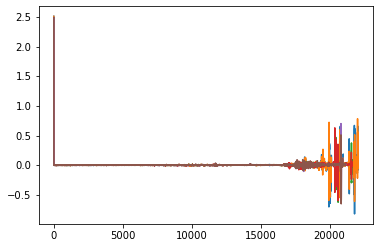

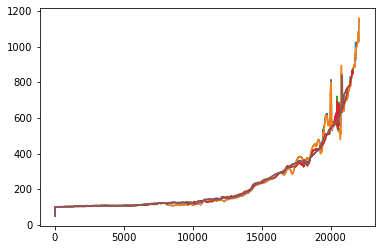

In [97]:
plt.figure()
for beam in beams:
    plt.plot(h_li_diff[cycles[0]][beam])
plt.figure()
for beam in beams:
    plt.plot(h_li[cycles[0]][beam])

In [13]:
import matplotlib.pyplot as plt

In [11]:

plt.figure()
plt.plot(corr2)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …